<h1>Real-time Political Sentiment Tracking for the 2020 USA General Election</h1>
This is a simple web app that analyses political sentiment for the upcoming US Election using information from Twitter. Twitter is the largest "micro-blogging" website allowing users to publish short messages up to 280 characters. The Twitter API provides a free tier of access which allows for a free tier of access to a small sample of their data. I do this by employing the textBlob library. I then create several visualizations using matplotlib, networkx and pyvis. 

<h3>Import packages and initialize some stuff</h3>

In [16]:
from operator import itemgetter
from textblob import TextBlob
import psycopg2
import json
import tweepy
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt2
from matplotlib.pyplot import figure
import networkx as nx
from tweepy import OAuthHandler
import threading
from nltk.tokenize import TweetTokenizer
tweet_tokenizer = TweetTokenizer()
#issues with nltk stopwords on heroku so manuallt populate
stopwords = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", \
"yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its",\
 "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this",\
 "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", \
 "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because",\
 "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", \
 "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out",\
 "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", \
 "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor",\
 "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don",\
 "should", "now", "http", "https", "co", "trump", "pence", "president", "mike pence", "realdonaldtrump", "mike_pence", \
 "biden", "joe biden", "haris", "kamala", "joe", "biden"]

<h3>Connect to Twitter API</h3>

In [17]:
#Twitter API credentials
consumer_key = 'xxxxxxxxxxxxxxxxx'
consumer_secret = 'xxxxxxxxxxxxxxxx'
access_token = 'xxxxxxxxxxxxxxxxxxxxx'
access_secret = 'xxxxxxxxxxxxxxxxxx'
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)

<h3>Connect to Postgresql Database</h3>

In [18]:
#Connect to postgresql database
connection = psycopg2.connect(user = "xxxxxxxxxxxxxxxxx",
                              password = "xxxxxxxxxxxxxxxxx",
                              host = "xxxxxxxxxxxxxxxxx",
                              port = "xxxxxxxxxxxxxxxxx",
                              database = "xxxxxxxxxxxxxxxxx")

<h2>Populate Database</h2>

In [19]:
#Using threading so that thread can continuously update database
class inserter(threading.Thread):
    def __init__(self):
        threading.Thread.__init__(self) 
        #initialize filters
        #Filters are essentially keywords grouped into lists for each stakeholder/contender under consideration
        #bobi corresponds to candidate Kyagulanyi SSentamu aka Bobi Wine
        #Kaguta corresponds to Yoweri Tubuhaburwa Kaguta Museveni
        #police corresponds to the Uganda Police
        #army corresponds to the army Uganda People's defence forces and Special Forces Command
        #intelligence corresponds to intelligence agencies
        #elections corresponds to elections in general
        self.contenders = [{'name':'biden', 'id': 1,
            'filters': ['biden', 'joe biden', 'dnc', 'kamala haris', 'democrat', 'democratic']},
                           {'name':'trump', 'id': 0,
            'filters': ['trump', 'rnc', 'republican', 'gop', 'donald trump', 'maga', 'mike pence']} ]
        self.location = '96683cc9126741d1'
        self.cursor = connection.cursor()

    #Constructing filters for Twitter's API given keywords
    def key_filter(self, terms):
        term_string = terms[0]
        filter_length = len(terms)
        current_index = 0
        if filter_length > 1:
            while current_index < filter_length - 1:
                current_index += 1
                term_string += " OR " + terms[current_index]
    
        return term_string
    
    def run(self):
        i = 0
        while i <= len(self.contenders):
            rule = "(place:{}) AND ({})".format(self.location, self.key_filter(self.contenders[i]['filters']))
            print(rule)
            c = tweepy.Cursor(api.search,q = rule).items()
            while True:
                source = None
                target = None
                try:
                    tweet = c.next()
                    text = tweet.text
                    if hasattr(tweet, 'retweeted_status'):
                        source = tweet.retweeted_status.author
                        target = tweet.user.name
                    elif hasattr(tweet, 'in_reply_to_screen_name'):
                        source = tweet.in_reply_to_screen_name
                        target = tweet.user.name
                    else:
                        source = tweet.user.name
                    try:
                        self.cursor.execute('INSERT INTO us_candidates(candidate, polarity, subjectivity, tweet_id, source, target, text, time, groups) VALUES \
                        (%s, %s, %s, %s, %s, %s, %s, %s, %s)', (self.contenders[i]['name'], TextBlob(text).sentiment[0], TextBlob(text).sentiment[1], \
                         tweet.id, source, target, text, tweet.created_at, self.contenders[i]['id']))
                        connection.commit()
                    except:
                        continue
                except tweepy.TweepError:
                    break
                except StopIteration:
                    break
            i += 1
            if(i == len(self.contenders)):
                i = 0

<h3>Run thread</h3>

In [20]:
t = inserter()
t.start()

(place:96683cc9126741d1) AND (biden OR joe biden OR dnc OR kamala haris OR democrat OR democratic)


<h2> Analyze Data </h2>

<h3>Frequent Terms </h3>

The word cloud can help reveal the important themes in the discourse. At the moment the moment Democratic themes seem to dominate the discourse.

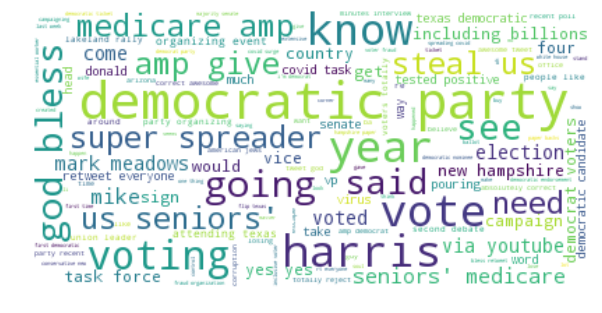

(place:96683cc9126741d1) AND (trump OR rnc OR republican OR gop OR donald trump OR maga OR mike pence)
(place:96683cc9126741d1) AND (trump OR rnc OR republican OR gop OR donald trump OR maga OR mike pence)


In [21]:
df_voca = pd.read_sql_query("SELECT text from us_candidates;", connection)
text = " ".join(tweet.lower() for tweet in df_voca.text)
figure(figsize=(10, 10))
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

<h2>Influential Users </h2>
The network diagram is a way to reveal th most influential individuals/ accounts. Each edge in the diagram implies a retweet/reply relationship between the two connected nodes. Nodes with more edges are more influential. Currently the republcan pair seems to be dominant in shaping the discourse as both Mike Pence and Donald Trump have dense retweet/reply networks.

In [22]:
node_links = pd.read_sql_query("SELECT source as target, target as source, groups as group from us_candidates\
    WHERE source IS NOT NULL;", connection)
G = nx.from_pandas_edgelist(node_links, "source", "target")
sources = pd.DataFrame(node_links['source'])
sources.rename(columns = {'source':'nodes'}, inplace = True) 
targets = pd.DataFrame(node_links['target'])
targets.rename(columns = {'target':'nodes'}, inplace = True)
nodes = sources.append(targets).nodes.unique()
attrs = {}
for node in nodes:
    attrs[node] = {'title': node, 'size': 1, 'value': 1 }
nx.set_node_attributes(G, attrs)
from pyvis.network import Network
net = Network(notebook=True, height="750", width="100%")
net.from_nx(G)
net.show("example.html")
#net.show_buttons(filter_=['physics'])


<img src="files/pic1.PNG">

<h2> Evolution of Public Interest over time</h2>
The time series graph show the evolution of the public's interest in a given stake-holder. The y-axis is the plot of the total mentions per stakeholder on a given date. We can see Trump and his Democratic challenger following almost identical trajectories although there is more public interest in Trump. There is a steep decline as we move from Sunday to Monday which could be the result of day-to-day shifts in tweeting frequency as the new work week begins and people emerge out of the weekend. However, Trump seems to benefit more from the weekend surge than Biden for whom interest is already on a downward turn from Saturday.

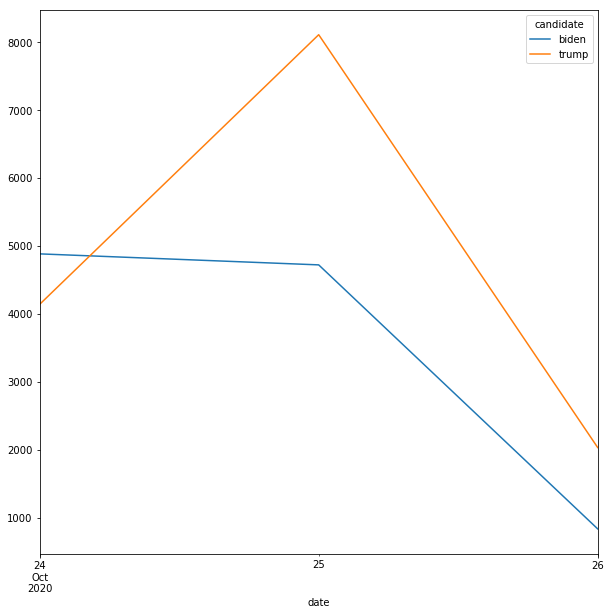

(place:96683cc9126741d1) AND (biden OR joe biden OR dnc OR kamala haris OR democrat OR democratic)
(place:96683cc9126741d1) AND (biden OR joe biden OR dnc OR kamala haris OR democrat OR democratic)
(place:96683cc9126741d1) AND (trump OR rnc OR republican OR gop OR donald trump OR maga OR mike pence)


In [23]:
df = pd.read_sql_query("SELECT candidate, TO_CHAR(time :: DATE, 'yyyymmdd') as date, 1 as count from us_candidates;", connection)
df['date'] = pd.to_datetime(df['date'], format="%Y%m%d")
df.sort_values(by=['date'], inplace=True)
data  = df.groupby(['date','candidate']).sum()['count']
data.unstack().plot(figsize=(10,10)) 
#plt.xticks(rotation=45) 
plt.show()


<h2>Polarity Vs Subjectivity</h2>
The Scatter plot shows the relationship between a stakeholder's polarity and subjectivity scores. The polarity is a measure of the public opinion of a stakeholder, the subjectivity measures the extent to which that opinion is specific to the authors of posts related to the specific stakeholder. Trump seems to have a lower favorability due to the low overall polarity but the opinions are highly subjective/ charged versus Biden who is the oppositte situation. 

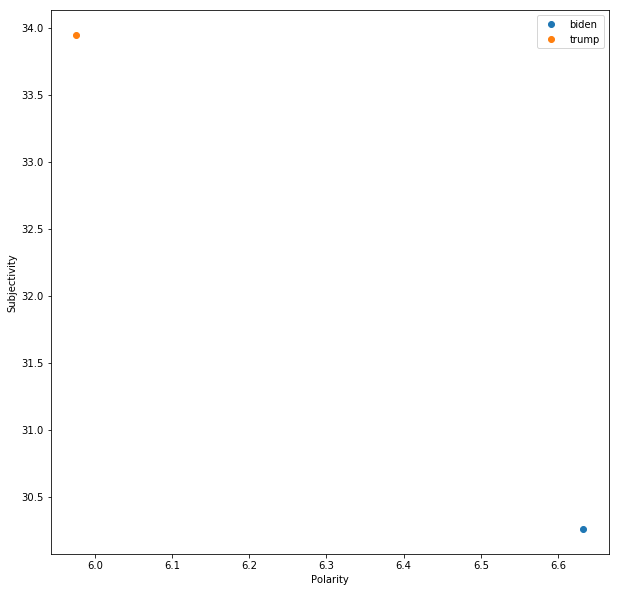

(place:96683cc9126741d1) AND (biden OR joe biden OR dnc OR kamala haris OR democrat OR democratic)


In [24]:
scatter_df = pd.read_sql_query("select candidate, avg(polarity) * 100 as Polarity, stddev(polarity) as stdevPolarity,\
    avg(subjectivity) * 100 as Subjectivity, stddev(subjectivity) as stdevSubjectivity from us_candidates GROUP BY candidate;", connection)
grouped_scatter = scatter_df.groupby("candidate")
figure(figsize=(10, 10))
for name, group in grouped_scatter:
    #details = name + "\n" + "StdevSubjectivity:" + str(group["subjectivity"])
    plt2.plot(group["polarity"], group["subjectivity"], marker="o", linestyle="", label=name)
plt2.legend() 
plt2.xlabel("Polarity")
plt2.ylabel("Subjectivity")
plt2.show()